# Homework 4: Conversation Modeling and decoding

In [0]:
import re
from collections import Counter
from tqdm import tqdm
import json
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
from utils import ChatDictionary, ChatDataset, pad_tensor, argsort, batchify, _HypothesisTail, reorder_encoder_states, reorder_decoder_incremental_state, get_nbest_list_from_beam

In [0]:
RETOK = re.compile(r'\w+|[^\w\s]|\n', re.UNICODE)

In [8]:
import os

### persona chat dataset
if not os.path.exists('./dict'):
    !wget "https://nyu.box.com/shared/static/sj9f87tofpicll89xbc154pmbztu5q4h" -O './dict'
if not os.path.exists('./train.jsonl'):
    !wget "https://nyu.box.com/shared/static/aqp0jyjaixjmukm5asasivq2bcfze075.jsonl" -O './train.jsonl'
if not os.path.exists('./valid.jsonl'):
    !wget "https://nyu.box.com/shared/static/eg4ivddtqib2hkf1k8rkxnmzmo0cq27p.jsonl" -O './valid.jsonl'

if not os.path.exists('./chat_model_best_22.pt'):
    !wget "https://nyu.box.com/shared/static/24zsynuks8nzg7530tgakzh8o62id9xa.pt" -O './chat_model_best_22.pt'

chat_dict = ChatDictionary('./dict')
train_dataset = ChatDataset('./train.jsonl', chat_dict)
valid_dataset = ChatDataset('./valid.jsonl', chat_dict, 'valid')

100%|██████████| 7801/7801 [00:00<00:00, 8168.02it/s]


In [0]:
train_loader = DataLoader(train_dataset, shuffle=True, collate_fn=batchify, batch_size=64)
valid_loader = DataLoader(valid_dataset, shuffle=False, collate_fn=batchify, batch_size=64)

# Part 1 Modeling

## 1.1 Attention visulization

In [12]:
# Based on the model from the lab
# code works on GPU and load the pretrained model 
current_device = 'cuda'
model_pt = torch.load('./chat_model_best_22.pt')
opts = model_pt['opts']    
model = seq2seq(opts)
model.load_state_dict(model_pt['state_dict'])
model.to(current_device)

seq2seq(
  (decoder): DecoderRNN(
    (dropout): Dropout(p=0.3, inplace=False)
    (embedding): Embedding(18760, 256, padding_idx=0)
    (gru): GRU(256, 512, batch_first=True)
    (attention): AttentionLayer(
      (linear_out): Linear(in_features=1024, out_features=512, bias=False)
      (softmax): Softmax(dim=-1)
      (tanh): Tanh()
    )
    (out): Linear(in_features=512, out_features=18760, bias=True)
  )
  (encoder): EncoderRNN(
    (dropout): Dropout(p=0.3, inplace=False)
    (embedding): Embedding(18760, 256, padding_idx=0)
    (gru): GRU(256, 512, batch_first=True)
  )
)

In [47]:
# get pre-processed data from valid_loader
plot_cache = []            
val_loss = 0
val_tokens = 0
for i, batch in enumerate(valid_loader):
    model.eval()
    print("batch is a dictionary {}".format(batch.keys()))
    text_vecs = batch['text_vecs'].to('cuda')
    target_vecs = batch['target_vecs'].to('cuda')
    
    encoded = model.encoder(text_vecs, batch['text_lens'], use_packed=batch['use_packed'])
    
    decoder_output, preds, attn_w_log = model.decoder.decode_forced(target_vecs, encoded, batch['text_lens'])
    
    scores = decoder_output.view(-1, decoder_output.size(-1))
    
    loss = criterion(scores, target_vecs.view(-1))
    
    num_tokens = target_vecs.ne(0).long().sum().item()
    
    val_tokens += num_tokens
    val_loss += loss.item()
    break     # we only want one batch 
    
avg_val_loss = val_loss/val_tokens
scheduler.step(avg_val_loss)

print("Epoch {} valid loss = {}".format(0, avg_val_loss))
plot_cache.append(avg_val_loss)

batch is a dictionary dict_keys(['text_vecs', 'text_lens', 'target_vecs', 'target_lens', 'use_packed'])
Epoch 0 valid loss = 3.7008329438840293


In [0]:
# get 5 examples from the batch generated before 
import numpy as np
sample_ids = np.random.randint(0,text_vecs.size(0),size = 5).tolist()

# get the attention list for the 5 examples
attention_list = []
for i in range(len(sample_ids)):
  # get sampel id and initialize the attention for this sample
  sample_id = sample_ids[i]
  attentions = torch.zeros((len(attn_w_log),text_vecs.size(1))) # shape: [22,243]
  for j in range(len(attn_w_log)): # len =22
    attentions[j,:] = attn_w_log[j][sample_id]
  # change it to an array
  attentions = attentions.detach().numpy()
  attention_list.append(attentions) # of length 5 

In [0]:
input_token_list = []
target_token_list = []
input_lens = []
target_lens = []
for sample_id in sample_ids:
  target_len = batch["target_lens"][sample_id]
  input_len = batch["text_lens"][sample_id]
  target_lens.append(target_len)
  input_lens.append(input_len)
  input_tokens = [chat_dict.ind2word[i] for i in text_vecs[sample_id][:input_len].tolist()]
  target_tokens = [chat_dict.ind2word[i] for i in target_vecs[sample_id][:target_len].tolist()]
  input_token_list.append(input_tokens)
  target_token_list.append(target_tokens)

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.ticker as ticker
from matplotlib import cm

In [0]:
def heatmap(index):
  attn = attention_list[index][:target_lens[index],:input_lens[index]] # [input,target]
  col_token = target_token_list[index] 
  row_token = input_token_list[index]

  # get the size of the figure
  fig = plt.figure(figsize = (30,5))
  ax = plt.gca()

  # Plot the heatmap
  im = ax.imshow(attn,interpolation='nearest',cmap = 'summer')
  
  # Create colorbar
  #cbar = ax.figure.colorbar(im, ax=ax,orientation = 'vertical')
  cbar = ax.figure.colorbar(im, ax=ax,orientation = 'vertical')
  cbar.ax.set_ylabel("Attention", rotation=-90, va="bottom")

  # Show all ticks and label them with the respective list entries.
  ax.set_xticks(np.arange(attn.shape[1]))
  ax.yaxis.tick_right()
  ax.set_yticks(np.arange(attn.shape[0]))
  ax.set_xticklabels(row_token,rotation=90, ha="right",rotation_mode="anchor")
  ax.set_yticklabels(col_token,ha="left",rotation_mode="anchor")
  
  plt.title('Attention map for example {}'.format(index+1))
  plt.ylabel('target sequence')
  plt.xlabel('input sequence')
  print("Input:",chat_dict.v2t(text_vecs[sample_ids[index]].tolist()[:input_lens[index]]))
  print("Target:",chat_dict.v2t(target_vecs[sample_ids[index]].tolist()[:target_lens[index]]))

  return im,cbar


Input: your persona : i have two dogs . 
 your persona : i like to work on vintage cars . 
 your persona : my favorite music is country . 
 your persona : i own two vintage mustangs . 
 hi ! how are you doing tonight ? 
 i ' m doing great . just relaxing with my two dogs . 
 great . in my spare time i do volunteer work .
Target: that ' s neat . what kind of volunteer work do you do ? __end__


(<matplotlib.image.AxesImage at 0x7f66c0443470>,
 <matplotlib.colorbar.Colorbar at 0x7f66c03e8e80>)

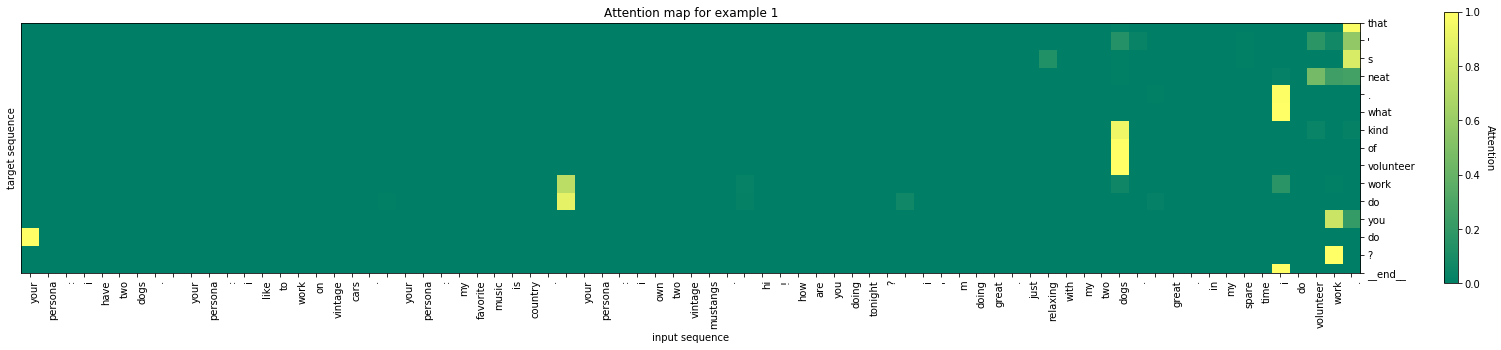

In [61]:
heatmap(0)

Input: your persona : i ' m a little girl . 
 your persona : i ' ve superpowers . 
 your persona : i like to make time stop . 
 your persona : i live in the cloud . 
 hi i dye my hair 4 times a year
Target: do you live in the sky ? i do . in the clouds . __end__


(<matplotlib.image.AxesImage at 0x7f66c031e6d8>,
 <matplotlib.colorbar.Colorbar at 0x7f66c02d7128>)

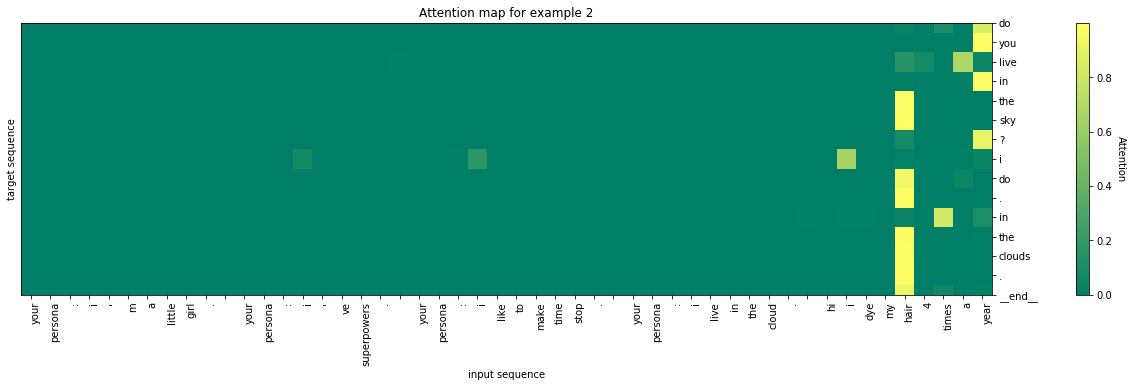

In [62]:
heatmap(1)

Input: your persona : i have two dogs . 
 your persona : i like to work on vintage cars . 
 your persona : my favorite music is country . 
 your persona : i own two vintage mustangs . 
 hi ! how are you doing tonight ? 
 i ' m doing great . just relaxing with my two dogs . 
 great . in my spare time i do volunteer work . 
 that ' s neat . what kind of volunteer work do you do ? 
 i work in a homeless shelter in my town . 
 good for you . do you like vintage cars ? i ' ve two older mustangs . 
 cool . not really into cars . my day job is wrestling . 
 cars are my thing . vintage cars . i love working on them . wrestling ? do you enjoy it ? 
 yes , i love the crowds , getting to know people .
Target: i didn ' t think about the crowd aspect of wrestling . i do not like crowds . __end__


(<matplotlib.image.AxesImage at 0x7f66c01c0470>,
 <matplotlib.colorbar.Colorbar at 0x7f66c0172e10>)

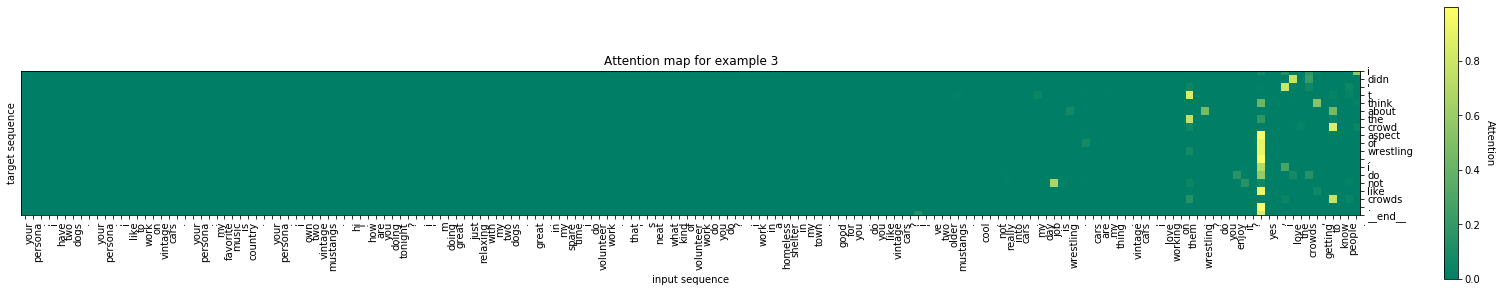

In [63]:
heatmap(2)

Input: your persona : i read twenty books a year . 
 your persona : i ' m a stunt double as my second job . 
 your persona : i only eat __unk__ . 
 your persona : i was raised in a single parent household . 
 hello what are doing today ?
Target: i am good , i just got off work and tired , i have two jobs . __end__


(<matplotlib.image.AxesImage at 0x7f66afe362e8>,
 <matplotlib.colorbar.Colorbar at 0x7f66afde5cf8>)

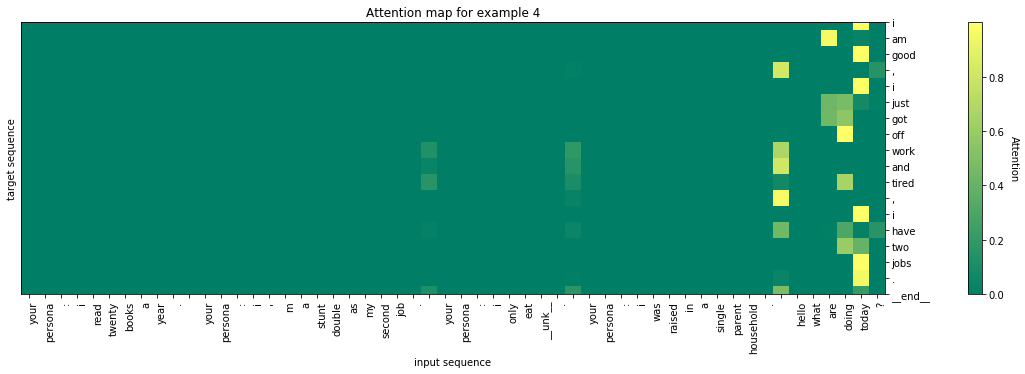

In [65]:
heatmap(3)

Input: your persona : i love to drink fancy tea . 
 your persona : i have a big library at home . 
 your persona : i ' m a museum tour guide . 
 your persona : i ' m partly deaf . 
 hi how are you doing ? i am okay how about you ? 
 i am doing good . just sipping tea . what do you do for work ? 
 i used to do home health aide but now i am disabled . 
 i am sorry to hear that . what happened 
 i graduated and got my license worked a while and became i ' ll . 
 so what do you do now for fun ? i like to read . 
 i have dogs and i walk them . and a cat . 
 what kind of dogs do you have ? 
 i enjoy reading read about michael jackson and psychology today . 
 i love reading . i have a big library at my house . 
 that ' s very nice i love to read to and read about journals . 
 i ' ve a tough time hearing so reading is my happy place . 
 cool that is okay . my mom was very tough on me .
Target: i work as a hearing impaired museum tour guide . __end__


(<matplotlib.image.AxesImage at 0x7f66afced438>,
 <matplotlib.colorbar.Colorbar at 0x7f66afc9ce48>)

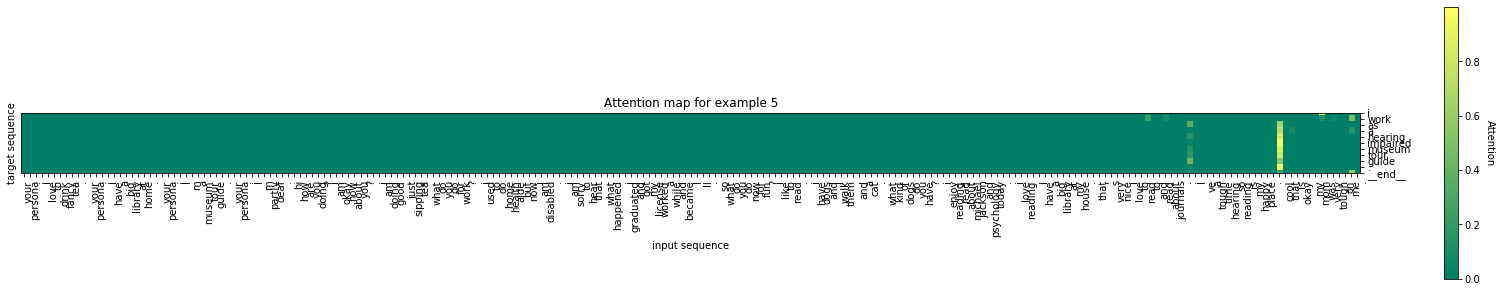

In [66]:
heatmap(4)

## 1.2 Encoder Transformer

In [0]:
### add transformer encoder as optional encoder in seq2seq model.

# code below can help you to start it, but feel free to start from scratch

import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import numpy as np
class EncoderRNN(nn.Module):
    """Encodes the input context."""

    # def __init__(self, vocab_size, embed_size, hidden_size, num_layers, pad_idx=0, dropout=0, shared_lt=None):
    #     super().__init__()
    #     self.vocab_size = vocab_size
    #     self.embed_size = embed_size
    #     self.hidden_size = hidden_size
    #     self.num_layers = num_layers
    #     self.dropout = nn.Dropout(p=dropout)
    #     self.pad_idx = pad_idx
        
    #     if shared_lt is None:
    #         self.embedding = nn.Embedding(self.vocab_size, self.embed_size, pad_idx)
    #     else:
    #         self.embedding = shared_lt
            
    #     self.gru = nn.GRU(
    #         self.embed_size, self.hidden_size, num_layers=self.num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0,
    #     )
        
        
    # def forward(self, text_vec, text_lens, hidden=None, use_packed=True):
    #     embedded = self.embedding(text_vec)
    #     attention_mask = text_vec.ne(self.pad_idx)

    #     embedded = self.dropout(embedded)
    #     if use_packed is True:
    #         embedded = pack_padded_sequence(embedded, text_lens, batch_first=True)
    #     output, hidden = self.gru(embedded, hidden)
    #     if use_packed is True:
    #         output, output_lens = pad_packed_sequence(output, batch_first=True)
        
    #     return output, hidden, attention_mask

    
    def __init__(self, vocab_size, embed_size, hidden_size, dropout, num_layers,shared_lt, max_len = 7500, nhead=4, pad_idx= 0):
        super(EncoderRNN, self).__init__()

        self.vocab_size = vocab_size
        self.max_len = max_len
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.nhead = nhead
        self.num_layers = num_layers
        self.pad_idx = pad_idx

        self.position_embed = nn.Embedding(num_embeddings = self.max_len, embedding_dim = self.embed_size)
        encoder_layer = nn.TransformerEncoderLayer(self.embed_size, self.nhead)
        self.transformer = nn.TransformerEncoder(encoder_layer, self.num_layers)
        self.token_embed = shared_lt
        self.dropout = nn.Dropout(p = self.dropout)

    def _generate_mask(self, sentence_len):
        "Mask out subsequent positions."
        attn_shape = (sentence_len, sentence_len)
        subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
        return torch.from_numpy(subsequent_mask) == 0

    def forward(self, text_vec, text_lens, hidden=None, use_packed=True): 
        # text_vec: batch x length 
        pos = torch.arange(text_vec.size(1), device = text_vec.device).expand(text_vec.size(0),-1).view(-1, text_vec.size(1))
        pos_embedded = self.position_embed(pos)
        tok_embedded = self.token_embed(text_vec)
        embedded = pos_embedded + tok_embedded  # apply pos embedding
        embedded = self.dropout(embedded)

        attention_mask_pos = self._generate_mask(text_vec.size(1))
        attention_mask_pad = text_vec.eq(self.pad_idx)
        
        output = self.transformer(embedded.transpose(0,1), 
                                  src_key_padding_mask=attention_mask_pad.to(text_vec.device),
                                  mask = attention_mask_pos.to(text_vec.device))
        output.transpose_(0,1)
        #print('output shape', output.size())
        hidden_encoder = torch.mean(output, dim = 1, keepdim=True).transpose(0,1).expand(2,-1,-1).contiguous() # 2 because decoder num_layers 
        #print('hidden layer shape', hidden_encoder.size())
        return output, hidden_encoder, attention_mask_pad
    

class DecoderRNN(nn.Module):
    """Generates a sequence of tokens in response to context."""

    def __init__(self, vocab_size, embed_size, hidden_size, num_layers, dropout=0):
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = nn.Dropout(p=dropout)
        
        self.embedding = nn.Embedding(self.vocab_size, self.embed_size, 0)
        
        self.gru = nn.GRU(
            self.embed_size, self.hidden_size, num_layers=self.num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0,
        )
        
        self.attention = AttentionLayer(self.hidden_size, self.embed_size)

        self.out = nn.Linear(self.hidden_size, self.vocab_size)
        self.longest_label = 100

    def forward(self, text_vec, decoder_hidden, encoder_states):
        emb = self.embedding(text_vec)
        emb = self.dropout(emb)
        seqlen = text_vec.size(1)
        encoder_output, encoder_hidden, attention_mask = encoder_states
        
        decoder_hidden = decoder_hidden
        output = []
        attn_w_log = []

        for i in range(seqlen):
            decoder_output, decoder_hidden = self.gru(emb[:,i,:].unsqueeze(1), decoder_hidden)
            
            # compute attention at each time step
            decoder_output_attended, attn_weights = self.attention(decoder_output, decoder_hidden, encoder_output, attention_mask)
            output.append(decoder_output_attended)
            attn_w_log.append(attn_weights)
            
        output = torch.cat(output, dim=1).to(text_vec.device)
        scores = self.out(output)
        

        return scores, decoder_hidden, attn_w_log
    
    def decode_forced(self, ys, encoder_states, xs_lens):
        encoder_output, encoder_hidden, attention_mask = encoder_states
        
        batch_size = ys.size(0)
        target_length = ys.size(1)
        longest_label = max(target_length, self.longest_label)
        
        starts = torch.Tensor([1]).long().to(self.embedding.weight.device).expand(batch_size, 1).long()  # expand to batch size
        
        # Teacher forcing: Feed the target as the next input
        y_in = ys.narrow(1, 0, ys.size(1) - 1)
        decoder_input = torch.cat([starts, y_in], 1)
        decoder_output, decoder_hidden, attn_w_log = self.forward(decoder_input, encoder_hidden, encoder_states)
        _, preds = decoder_output.max(dim=2)
        
        return decoder_output, preds, attn_w_log
    
    
class AttentionLayer(nn.Module):

    def __init__(self, hidden_size, embedding_size):
        super().__init__()
        input_dim = hidden_size

        self.linear_out = nn.Linear(hidden_size+input_dim, input_dim, bias=False)
        self.softmax = nn.Softmax(dim=-1)
        self.tanh = nn.Tanh()

    def forward(self, decoder_output, decoder_hidden, encoder_output, attention_mask):

        batch_size, seq_length, hidden_size = encoder_output.size()

        encoder_output_t = encoder_output.transpose(1,2)
        
        attention_scores = torch.bmm(decoder_output, encoder_output_t).squeeze(1)

        attention_scores.masked_fill_((attention_mask), -10e5)
        attention_weights = self.softmax(attention_scores)

        mix = torch.bmm(attention_weights.unsqueeze(1), encoder_output)

        combined = torch.cat((decoder_output.squeeze(1), mix.squeeze(1)), dim=1)

        output = self.linear_out(combined).unsqueeze(1)
        output = self.tanh(output)

        return output, attention_weights
    
class seq2seq(nn.Module):
    """
    Generic seq2seq model with attention mechanism.
    """
    def __init__(self, opts):

        super().__init__()
        self.opts = opts
        
        self.decoder = DecoderRNN(
                                    vocab_size=self.opts['vocab_size'],
                                    embed_size=self.opts['embedding_size'],
                                    hidden_size=self.opts['hidden_size'],
                                    num_layers=self.opts['num_layers_dec'],
                                    dropout=self.opts['dropout'],
                                )
        
        self.encoder = EncoderRNN(
                                    vocab_size=self.opts['vocab_size'],
                                    embed_size=self.opts['embedding_size'],
                                    hidden_size=self.opts['hidden_size'],
                                    num_layers=self.opts['num_layers_enc'],
                                    dropout=self.opts['dropout'],
                                    shared_lt=self.decoder.embedding,
                                    # ### Transformer
                                    # max_len = self.opts['max_len'],
                                    # nhead = self.opts['nhead'],
    
        )
        
    def train(self):
        self.encoder.train()
        self.decoder.train()
        
    def eval(self):
        self.encoder.eval()
        self.decoder.eval()

In [0]:
num_gpus = torch.cuda.device_count()
if num_gpus > 0:
    current_device = 'cuda'
else:
    current_device = 'cpu'

load_pretrained = False
    
if load_pretrained is True:
    if current_device == 'cuda':
        model_pt = torch.load('./transformer_best_6.pt')
    else:
        model_pt = torch.load('./transformer_best_6.pt', map_location=torch.device('cpu'))
    opts = model_pt['opts']
    
    model = seq2seq(opts)
    model.load_state_dict(model_pt['state_dict'])
    model.to(current_device)
    
else:
    
    opts = {}

    opts['vocab_size'] = len(chat_dict)
    opts['hidden_size'] = 256
    opts['embedding_size'] = 256
    opts['num_layers_enc'] = 2
    opts['num_layers_dec'] = 2
    opts['dropout'] = 0.3
    opts['encoder_shared_lt'] = True
    
    ### Transformer 
    # opts['max_len'] = 7500
    # opts['nhead'] = 4
    
    
    model = seq2seq(opts)
    model.to(current_device)

In [0]:
criterion = nn.CrossEntropyLoss(ignore_index=0, reduction='sum')
optimizer = torch.optim.AdamW(model.parameters(), 0.001, amsgrad=True, weight_decay = 0.01) # AdamW is Adam + weight decay
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10)

In [0]:
# check pdf to see what you expected to present

In [0]:
plot_cache = []

best_val_loss = 100

for epoch in range(30):
    
    model.train()
    sum_loss = 0
    sum_tokens = 0
    
    for i, batch in enumerate(train_loader):
        optimizer.zero_grad()
        
        text_vecs = batch['text_vecs'].to('cuda')
        target_vecs = batch['target_vecs'].to('cuda')
 
        encoded = model.encoder(text_vecs, batch['text_lens'], use_packed=batch['use_packed'])
        
        decoder_output, preds, attn_w_log = model.decoder.decode_forced(target_vecs, encoded, batch['text_lens'])
        
        scores = decoder_output.view(-1, decoder_output.size(-1))
        
        loss = criterion(scores, target_vecs.view(-1))
        sum_loss += loss.item()
        
        num_tokens = target_vecs.ne(0).long().sum().item()
        loss /= num_tokens
        
        sum_tokens += num_tokens
        
        loss.backward()
        optimizer.step()
        
        if i % 100 == 0:
            avg_train_loss = sum_loss/sum_tokens
            print("iter {} train loss = {}".format(i, sum_loss/sum_tokens))

    val_loss = 0
    val_tokens = 0
    for i, batch in enumerate(valid_loader):
        model.eval()
        
        text_vecs = batch['text_vecs'].to('cuda')
        target_vecs = batch['target_vecs'].to('cuda')
        
        encoded = model.encoder(text_vecs, batch['text_lens'], use_packed=batch['use_packed'])
        #encoded = model.encoder(text_vecs)
        
        decoder_output, preds, attn_w_log = model.decoder.decode_forced(target_vecs, encoded, batch['text_lens'])
        
        scores = decoder_output.view(-1, decoder_output.size(-1))
        
        loss = criterion(scores, target_vecs.view(-1))
        
        num_tokens = target_vecs.ne(0).long().sum().item()
        
        val_tokens += num_tokens
        val_loss += loss.item()
        
    avg_val_loss = val_loss/val_tokens
    val_perp = np.exp(avg_val_loss)
    scheduler.step(avg_val_loss)
        
    print("Epoch {} valid loss = {}".format(epoch, avg_val_loss))
    print("Epoch {} valid perp = {}".format(epoch, val_perp))
    
    plot_cache.append( (avg_train_loss, avg_val_loss) )
    
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        
        torch.save({
        'state_dict': model.state_dict(),
        'opts': opts,
        'plot_cache': plot_cache,
            }, f'./transformer_best_{epoch}.pt')

iter 0 train loss = 9.861941372112984
iter 100 train loss = 5.971185261298769
iter 200 train loss = 5.518927177815331
iter 300 train loss = 5.232503547691666
iter 400 train loss = 5.037795903197501
iter 500 train loss = 4.89660920616663
iter 600 train loss = 4.794661637683474
iter 700 train loss = 4.715725839428522
iter 800 train loss = 4.647014741135447
iter 900 train loss = 4.588638307202965
iter 1000 train loss = 4.538578561223573
iter 1100 train loss = 4.494452043789565
iter 1200 train loss = 4.456141659788502
iter 1300 train loss = 4.422082164415175
iter 1400 train loss = 4.391696713252875
iter 1500 train loss = 4.364642817884551
iter 1600 train loss = 4.339133131268906
iter 1700 train loss = 4.316718772028358
iter 1800 train loss = 4.295627925188392
iter 1900 train loss = 4.277680073069002
iter 2000 train loss = 4.260150919788498
Epoch 0 valid loss = 3.9511326420934987
Epoch 0 valid perp = 51.994224343403474
iter 0 train loss = 3.661064808461418
iter 100 train loss = 3.7921958111

iter 1800 train loss = 3.3386566210260376
iter 1900 train loss = 3.3400878596757853
iter 2000 train loss = 3.341656234411288
Epoch 8 valid loss = 3.7373228119580024
Epoch 8 valid perp = 41.98543665980985
iter 0 train loss = 3.054618942086245
iter 100 train loss = 3.2877651360570983
iter 200 train loss = 3.2891091297497383
iter 300 train loss = 3.2933186650195734
iter 400 train loss = 3.293524154547039
iter 500 train loss = 3.2955450623035443
iter 600 train loss = 3.292615239387801
iter 700 train loss = 3.2958825643138145
iter 800 train loss = 3.300872972768649
iter 900 train loss = 3.30015292955547
iter 1000 train loss = 3.301979589005867
iter 1100 train loss = 3.3041936825103364
iter 1200 train loss = 3.3062844332276926
iter 1300 train loss = 3.307355339592819
iter 1400 train loss = 3.3095116131856703
iter 1500 train loss = 3.3123905163767455
iter 1600 train loss = 3.313059813067537
iter 1700 train loss = 3.3143826449986196
iter 1800 train loss = 3.3153266774506447
iter 1900 train los

iter 1200 train loss = 3.162484079450204
iter 1300 train loss = 3.164635838121023
iter 1400 train loss = 3.165581576564407
iter 1500 train loss = 3.166534216717141
iter 1600 train loss = 3.1681046945788287
iter 1700 train loss = 3.169740079471297
iter 1800 train loss = 3.1714903678094197
iter 1900 train loss = 3.174128256964319
iter 2000 train loss = 3.1754388729310916
Epoch 17 valid loss = 3.750923181443588
Epoch 17 valid perp = 42.56035479909694
iter 0 train loss = 3.0940872012867646
iter 100 train loss = 3.1032023231888193
iter 200 train loss = 3.115444575753218
iter 300 train loss = 3.1177709981621486
iter 400 train loss = 3.121725518583685
iter 500 train loss = 3.126718572066792
iter 600 train loss = 3.130486608852637
iter 700 train loss = 3.133430468192216
iter 800 train loss = 3.135011747401587
iter 900 train loss = 3.1398853118472765
iter 1000 train loss = 3.1432955740242545
iter 1100 train loss = 3.144834224560041
iter 1200 train loss = 3.1475188081625802
iter 1300 train loss 

iter 600 train loss = 2.9946506740561714
iter 700 train loss = 2.9963002558101333
iter 800 train loss = 2.997952004542492
iter 900 train loss = 2.9994965012531654
iter 1000 train loss = 3.0002327128563735
iter 1100 train loss = 3.0006245937991536
iter 1200 train loss = 3.001284492210663
iter 1300 train loss = 3.001194202513145
iter 1400 train loss = 3.0021843568649724
iter 1500 train loss = 3.0029604136089767
iter 1600 train loss = 3.003655637574926
iter 1700 train loss = 3.0044330287767984
iter 1800 train loss = 3.005351474014864
iter 1900 train loss = 3.0055567779203236
iter 2000 train loss = 3.0051415993425588
Epoch 26 valid loss = 3.7040063703880644
Epoch 26 valid perp = 40.609676286385344
iter 0 train loss = 3.1951957239389714
iter 100 train loss = 3.001914056519682
iter 200 train loss = 2.9943953453417502
iter 300 train loss = 2.9884454162180685
iter 400 train loss = 2.9903382731632773
iter 500 train loss = 2.9899682000887235
iter 600 train loss = 2.9926557243044245
iter 700 trai

In [0]:
# model_name = './transformer_best_0.pt'

# num_gpus = torch.cuda.device_count()
# if num_gpus > 0:
#     current_device = 'cuda'
# else:
#     current_device = 'cpu'

# if current_device == 'cuda':
#     model_pt = torch.load(model_name)
# else:
#     model_pt = torch.load(model_name, map_location=torch.device('cpu'))
# opts = model_pt['opts']

# model = seq2seq(opts)
# model.load_state_dict(model_pt['state_dict'])
# model.to(current_device)

# plot_cache = model_pt['plot_cache']

## You present here:

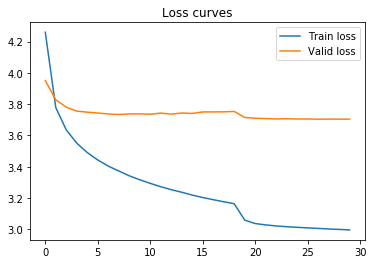

In [0]:
import matplotlib.pyplot as plt
import numpy

# plot_cache = model_pt['plot_cache']

epochs = numpy.array(list(range(len(plot_cache))))
plt.plot(epochs, [i[0] for i in plot_cache], label='Train loss')
plt.plot(epochs, [i[1] for i in plot_cache], label='Valid loss')

plt.legend()
plt.title('Loss curves')
plt.show()

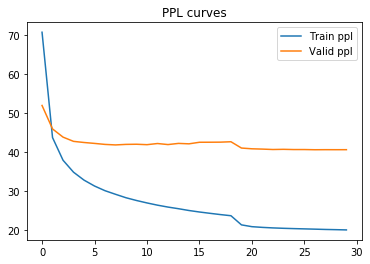

In [0]:
import matplotlib.pyplot as plt
import numpy

epochs = numpy.array(list(range(len(plot_cache))))
plt.plot(epochs, [2**(i[0]/numpy.log(2)) for i in plot_cache], label='Train ppl')
plt.plot(epochs, [2**(i[1]/numpy.log(2)) for i in plot_cache], label='Valid ppl')

plt.legend()
plt.title('PPL curves')
plt.show()

# Part 2 Decoding

# 2.1 Nucleus Sampling

In [0]:
class ChatDictionary(object):
    """
    Simple dict loader
    """
    def __init__(self, dict_file_path):
        self.word2ind = {}  # word:index
        self.ind2word = {}  # index:word
        self.counts = {}  # word:count

        dict_raw = open(dict_file_path, 'r').readlines()
        
        for i, w in enumerate(dict_raw):
            _word, _count = w.strip().split('\t')
            if _word == '\\n':
                _word = '\n'
            self.word2ind[_word] = i
            self.ind2word[i] = _word
            self.counts[_word] = _count
            
    def t2v(self, tokenized_text):
        return [self.word2ind[w] if w in self.counts else self.word2ind['__unk__'] for w in tokenized_text]

    def v2t(self, list_ids):
        return ' '.join([self.ind2word[i] for i in list_ids])
    
    def pred2text(self, tensor):
        result = []
        for i in range(tensor.size(0)):
            if tensor[i].item() == '__end__'  or tensor[i].item() == '__null__':  # null is pad
                break
            else:
                result.append(self.ind2word[tensor[i].item()])
        return ' '.join(result)
    
    def __len__(self):
        return len(self.counts)

In [0]:
RETOK = re.compile(r'\w+|[^\w\s]|\n', re.UNICODE)
class ChatDataset(Dataset):
    """
    Json dataset wrapper
    """
    
    def __init__(self, dataset_file_path, dictionary, dt='train'):
        super().__init__()
        
        json_text = open(dataset_file_path, 'r').readlines()
        self.samples = []
        
        for sample in tqdm(json_text):
            sample = sample.rstrip()
            sample = json.loads(sample)
            _inp_toked = RETOK.findall(sample['text'])
            _inp_toked_id = dictionary.t2v(_inp_toked)

            sample['text_vec'] = torch.tensor(_inp_toked_id, dtype=torch.long)
            
            # train and valid have different key names for target
            if dt == 'train':
                _tar_toked = RETOK.findall(sample['labels'][0]) + ['__end__']
            elif dt == 'valid':
                _tar_toked = RETOK.findall(sample['eval_labels'][0]) + ['__end__']
                
            _tar_toked_id = dictionary.t2v(_tar_toked)
            
            sample['target_vec'] = torch.tensor(_tar_toked_id, dtype=torch.long)
            
            self.samples.append(sample)
            
    def __getitem__(self, i):
        return self.samples[i]['text_vec'], self.samples[i]['target_vec']
    
    def __len__(self):
        return len(self.samples)

In [0]:
def pad_tensor(tensors, sort=True, pad_token=0):
    rows = len(tensors)
    lengths = [len(i) for i in tensors]
    max_t = max(lengths)
        
    output = tensors[0].new(rows, max_t)
    output.fill_(pad_token)  # 0 is a pad token here
    
    for i, (tensor, length) in enumerate(zip(tensors, lengths)):
        output[i,:length] = tensor

    return output, lengths

def argsort(keys, *lists, descending=False):
    """Reorder each list in lists by the (descending) sorted order of keys.
    :param iter keys: Keys to order by.
    :param list[list] lists: Lists to reordered by keys's order.
                             Correctly handles lists and 1-D tensors.
    :param bool descending: Use descending order if true.
    :returns: The reordered items.
    """
    ind_sorted = sorted(range(len(keys)), key=lambda k: keys[k])
    if descending:
        ind_sorted = list(reversed(ind_sorted))
    output = []
    for lst in lists:
        if isinstance(lst, torch.Tensor):
            output.append(lst[ind_sorted])
        else:
            output.append([lst[i] for i in ind_sorted])
    return output

def batchify(batch):
    inputs = [i[0] for i in batch]
    labels = [i[1] for i in batch]
    
    input_vecs, input_lens = pad_tensor(inputs)
    label_vecs, label_lens = pad_tensor(labels)
    
    # sort only wrt inputs here for encoder packinng
    input_vecs, input_lens, label_vecs, label_lens = argsort(input_lens, input_vecs, input_lens, label_vecs, label_lens, descending=True)

    return {
        "text_vecs": input_vecs,
        "text_lens": input_lens,
        "target_vecs": label_vecs,
        "target_lens": label_lens,
        'use_packed': True
    }

In [0]:
train_loader = DataLoader(train_dataset, shuffle=True, collate_fn=batchify, batch_size=256)
valid_loader = DataLoader(valid_dataset, shuffle=False, collate_fn=batchify, batch_size=256)

In [0]:
# Lab code from chat.ipynb
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class EncoderRNN(nn.Module):
    """Encodes the input context."""

    def __init__(self, vocab_size, embed_size, hidden_size, num_layers, pad_idx=0, dropout=0, shared_lt=None):
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = nn.Dropout(p=dropout)
        self.pad_idx = pad_idx
        
        if shared_lt is None:
            self.embedding = nn.Embedding(self.vocab_size, self.embed_size, pad_idx)
        else:
            self.embedding = shared_lt
            
        self.gru = nn.GRU(
            self.embed_size, self.hidden_size, num_layers=self.num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0,
        )
        
        
    def forward(self, text_vec, text_lens, hidden=None, use_packed=True):
        embedded = self.embedding(text_vec)
        attention_mask = text_vec.ne(self.pad_idx) # ne function calculates not equal to element-wise
        
        embedded = self.dropout(embedded)
        if use_packed is True:
            embedded = pack_padded_sequence(embedded, text_lens, batch_first=True)
        output, hidden = self.gru(embedded, hidden)
        if use_packed is True:
            output, output_lens = pad_packed_sequence(output, batch_first=True)
        
        return output, hidden, attention_mask

    
class DecoderRNN(nn.Module):
    """Generates a sequence of tokens in response to context."""

    def __init__(self, vocab_size, embed_size, hidden_size, num_layers, dropout=0):
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = nn.Dropout(p=dropout)
        
        self.embedding = nn.Embedding(self.vocab_size, self.embed_size, 0)
        
        self.gru = nn.GRU(
            self.embed_size, self.hidden_size, num_layers=self.num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0,
        )
        
        self.attention = AttentionLayer(self.hidden_size, self.embed_size)

        self.out = nn.Linear(self.hidden_size, self.vocab_size)
        self.longest_label = 100

    def forward(self, text_vec, decoder_hidden, encoder_states):
        emb = self.embedding(text_vec)
        emb = self.dropout(emb)
        seqlen = text_vec.size(1)
        encoder_output, encoder_hidden, attention_mask = encoder_states
        
        decoder_hidden = decoder_hidden
        output = []
        attn_w_log = []

        for i in range(seqlen):
            decoder_output, decoder_hidden = self.gru(emb[:,i,:].unsqueeze(1), decoder_hidden)
            
            # compute attention at each time step
            decoder_output_attended, attn_weights = self.attention(decoder_output, decoder_hidden, encoder_output, attention_mask)
            output.append(decoder_output_attended)
            attn_w_log.append(attn_weights)
            
        output = torch.cat(output, dim=1).to(text_vec.device)
        scores = self.out(output)
        
        return scores, decoder_hidden, attn_w_log
    
    def decode_forced(self, ys, encoder_states, xs_lens):
        encoder_output, encoder_hidden, attention_mask = encoder_states
        
        batch_size = ys.size(0)
        target_length = ys.size(1)
        longest_label = max(target_length, self.longest_label)
        
        starts = torch.Tensor([1]).long().to(self.embedding.weight.device).expand(batch_size, 1).long()  # expand to batch size
        
        # Teacher forcing: Feed the target as the next input
        y_in = ys.narrow(1, 0, ys.size(1) - 1)
        decoder_input = torch.cat([starts, y_in], 1)
        decoder_output, decoder_hidden, attn_w_log = self.forward(decoder_input, encoder_hidden, encoder_states)
        _, preds = decoder_output.max(dim=2)
        
        return decoder_output, preds, attn_w_log
    
    
class AttentionLayer(nn.Module):

    def __init__(self, hidden_size, embedding_size):
        super().__init__()
        input_dim = hidden_size

        self.linear_out = nn.Linear(hidden_size+input_dim, input_dim, bias=False)
        self.softmax = nn.Softmax(dim=-1)
        self.tanh = nn.Tanh()

    def forward(self, decoder_output, decoder_hidden, encoder_output, attention_mask):

        batch_size, seq_length, hidden_size = encoder_output.size()

        encoder_output_t = encoder_output.transpose(1,2)
        
        attention_scores = torch.bmm(decoder_output, encoder_output_t).squeeze(1)

        attention_scores.masked_fill_((~attention_mask), -10e5)
        attention_weights = self.softmax(attention_scores)

        mix = torch.bmm(attention_weights.unsqueeze(1), encoder_output)

        combined = torch.cat((decoder_output.squeeze(1), mix.squeeze(1)), dim=1)

        output = self.linear_out(combined).unsqueeze(1)
        output = self.tanh(output)

        return output, attention_weights
    
    
class seq2seq(nn.Module):
    """
    Generic seq2seq model with attention mechanism.
    """
    def __init__(self, opts):

        super().__init__()
        self.opts = opts
        
        self.decoder = DecoderRNN(
                                    vocab_size=self.opts['vocab_size'],
                                    embed_size=self.opts['embedding_size'],
                                    hidden_size=self.opts['hidden_size'],
                                    num_layers=self.opts['num_layers_dec'],
                                    dropout=self.opts['dropout'],
                                )
        
        self.encoder = EncoderRNN(
                                    vocab_size=self.opts['vocab_size'],
                                    embed_size=self.opts['embedding_size'],
                                    hidden_size=self.opts['hidden_size'],
                                    num_layers=self.opts['num_layers_enc'],
                                    dropout=self.opts['dropout'],
                                    shared_lt=self.decoder.embedding
        )
        
    def train(self):
        self.encoder.train()
        self.decoder.train()
        
    def eval(self):
        self.encoder.eval()
        self.decoder.eval()

In [0]:
num_gpus = torch.cuda.device_count()
if num_gpus > 0:
    current_device = 'cuda'
else:
    current_device = 'cpu'

load_pretrained = True
    
if load_pretrained is True:
    if current_device == 'cuda':
        model_pt = torch.load('./chat_model_best_22.pt')
    else:
        model_pt = torch.load('./chat_model_best_22.pt', map_location=torch.device('cpu'))
    opts = model_pt['opts']
    
    model = seq2seq(opts)
    model.load_state_dict(model_pt['state_dict'])
    model.to(current_device)

In [0]:
# implement nucleus sampling here.
# you must cite any code you use from other sources!
import numpy as np

def nucleus_sampling(model, batch, batch_size, prob_thre):
    """
    batch: the input batch which we want to sample the output on
    batch_size: the relative batch size
    prob_thre: the probability threshold to choose top p next token
    """
    model.eval()
    with torch.no_grad():
        text_vecs = batch['text_vecs'].to(current_device)
        encoded = model.encoder(text_vecs, batch['text_lens'], use_packed=batch['use_packed'])
        encoder_output, encoder_hidden, attention_mask = encoded

        # First define __start__ as the starting point of our sampling
        starts = torch.Tensor([1]).long().to(model.decoder.embedding.weight.device).expand(batch_size, 1).long()  # expand to batch size
        decoder_hidden = encoder_hidden

        # Start sampling
        samp = [starts]
        probs_selecting = []

        # We want to stop when every sequence has 2 as their ends (2 == __end__)
        finish_mask = torch.Tensor([0]*batch_size).byte().to(model.decoder.embedding.weight.device)
        current_sequences = starts
        _attn_w_log = []

        def find_indices(sorted_prob, prob_thre): 
            # Given a sorted probs, return the number of probs and sum of probs that could add up to >= threshold     
            sum_now = 0
            count = 0
            while sum_now < prob_thre:
                sum_now += sorted_prob[count].item()
                count += 1
            return count, sum_now

        for time_step in range(1000):
            decoder_output, decoder_hidden, attn_w_log = model.decoder(current_sequences, decoder_hidden, encoded)
            all_probs = torch.softmax(decoder_output, dim=-1)
            new_samp_all = []
            new_prob_list = []
            for i in range(batch_size):
                single_next = all_probs[i, :, :].squeeze()
                _probs, _indices = torch.sort(single_next, descending=True)
                count, sum_p = find_indices(_probs, prob_thre)
                new_probs = _probs[:count] / sum_p
                _indices = _indices[:count]
                # Now sample an index from the new conditional distribution
                new_pred = _indices[torch.multinomial(new_probs, 1)].view(-1, 1).long()
                prob_for_this_token = _probs[new_pred.item()].view(-1, 1)
                #new_pred = torch.Tensor([np.random.choice(_indices, p = _probs)]).view(-1, 1).long()
                new_samp_all.append(new_pred)
                new_prob_list.append(prob_for_this_token)

            _samp = torch.cat(new_samp_all, dim=1).to(model.decoder.embedding.weight.device)
            prob_batch = torch.cat(new_prob_list, dim=1).to(model.decoder.embedding.weight.device)
            samp.append(_samp)
            probs_selecting.append(prob_batch)
            _attn_w_log.append(attn_w_log)

            finish_mask += (_samp == 2).byte().view(-1)
            
            if not (torch.any(~finish_mask.bool())): # ~ is invert
                break
            
            current_sequences = _samp
        
        samp = torch.cat(samp, dim=-1)
        probs_selecting = torch.cat(probs_selecting, dim=-1)
            
    return samp, probs_selecting

In [0]:
# A test run
inputs = RETOK.findall("your persona: i live in texas.\n hello , where are you ? ?")

test_batch = {
    'text_vecs': torch.tensor([chat_dict.t2v(inputs)], dtype=torch.long, device=model.decoder.embedding.weight.device),
    'text_lens': torch.tensor([len(inputs)], dtype=torch.long),
    'use_packed': True,
}

sample, probs = nucleus_sampling(model, test_batch, 1, 0.1)#.tolist()
print(chat_dict.v2t(*sample.tolist()))
print(np.average(np.log(probs.tolist())))

__start__ i am from california , where are you from ? __end__
-7.423248277044979


## You present here:

Our input is: your persona : i read twenty books a year . 
 your persona : i ' m a stunt double as my second job . 
 your persona : i only eat __unk__ . 
 your persona : i was raised in a single parent household . 
 hello what are doing today ?


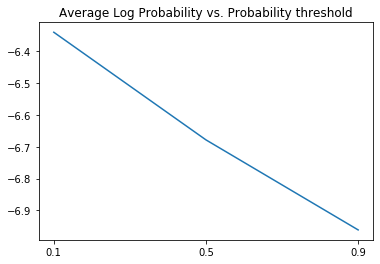

In [0]:
# Section 2.1
# Q2 and Q3
import matplotlib.pyplot as plt

number_decodings = 100
prob_thre_list = [0.1, 0.5, 0.9]
# Selecting a single input from the validation set
index = 0
valid_input = valid_dataset[index][0]
print(f"Our input is: {chat_dict.v2t(valid_input.tolist())}")
test_input = {
    'text_vecs': valid_input.view(1, -1).to(model.decoder.embedding.weight.device),
    'text_lens': torch.tensor([len(valid_input)], dtype=torch.long),
    'use_packed': True,
}

# Compute the average log-probability of generated sequences for each value of prob_thre
# Also store the samples
log_p_dict = {}
all_samples = {}
for thre in prob_thre_list:
    log_p_dict[thre] = []
    all_samples[thre] = []
    for i in range(number_decodings):
        sample, probs = nucleus_sampling(model, test_input, 1, thre)
        # Store the sample
        all_samples[thre].append(*sample.tolist())
        # Compute log_p and add them up
        log_p_total = torch.mean(torch.log(probs))
        log_p_dict[thre].append(log_p_total)

avg_log_p = [np.mean(log_p_dict[i]) for i in log_p_dict]
plt.plot(prob_thre_list, avg_log_p)
plt.title("Average Log Probability vs. Probability threshold")
plt.xticks([0.1, 0.5, 0.9])
plt.show()

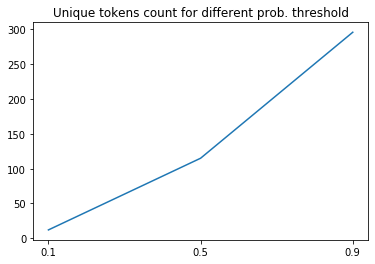

In [0]:
# Q3's plot
unique_token_count = []
for thre in all_samples:
    all_tokens = []
    [all_tokens.extend(l) for l in all_samples[thre]]
    unique_token_count.append(len(set(all_tokens)))

# Plot
plt.plot(prob_thre_list, unique_token_count)
plt.title("Unique tokens count for different prob. threshold")
plt.xticks([0.1, 0.5, 0.9])
plt.show()

## 2.2 N-Gram blocking

In [0]:
model_name = './chat_model_best_22.pt'

num_gpus = torch.cuda.device_count()
if num_gpus > 0:
    current_device = 'cuda'
else:
    current_device = 'cpu'

if current_device == 'cuda':
    model_pt = torch.load(model_name)
else:
    model_pt = torch.load(model_name, map_location=torch.device('cpu'))
opts = model_pt['opts']

model = seq2seq(opts)
model.load_state_dict(model_pt['state_dict'])
model.to(current_device)

plot_cache = model_pt['plot_cache']

In [0]:
import math
from operator import attrgetter


class Beam(object):
    """
    This class serves to keep info about partial hypothesis and perform the beam step
    """
    
    def __init__(
        self,
        beam_size,
        padding_token=0,
        bos_token=1,
        eos_token=2,
        min_length=3,
        min_n_best=3,
        device='cpu',
        # for iterbeam below
        similarity_metric='hamming',
        similarity_threshold=0,
        N = 3
    ):
        
        self.beam_size = beam_size
        self.min_length = min_length
        self.eos = eos_token
        self.bos = bos_token
        self.pad = padding_token
        self.device = device
        # recent score for each hypo in the beam
        self.scores = None
        # self.scores values per each time step
        self.all_scores = [torch.Tensor([0.0] * beam_size).to(self.device)]
        # backtracking id to hypothesis at previous time step
        self.bookkeep = []
        # output tokens at each time step
        self.outputs = [
            torch.Tensor(self.beam_size).long().fill_(self.bos).to(self.device)
        ]
        # keeps tuples (score, time_step, hyp_id)
        self.finished = []
        self.eos_top = False
        self.eos_top_ts = None
        self.n_best_counter = 0
        self.min_n_best = min_n_best
        self.partial_hyps = [[self.bos] for i in range(beam_size)]

        # iterbeam related below
        self.history_hyps = []
        self.similarity_metric = similarity_metric
        self.similarity_threshold = similarity_threshold
        self.banned_tokens = set()
        
        ### N-gram blocking
        self.N = N
      
    def get_output_from_current_step(self):
        """Get the output at the current step."""
        return self.outputs[-1]

    def get_backtrack_from_current_step(self):
        """Get the backtrack at the current step."""
        return self.bookkeep[-1]
    
    ##################### ITER-BEAM BLOCKING PART START #####################
    
    def hamming_distance(self, t1, t2):
        dist = 0
        for tok1, tok2 in zip(t1,t2):
            if tok1 != tok2:
                dist += 1
        return dist
    
    def edit_distance(self, t1, t2):
        import editdistance
        dist = editdistance.eval(t1, t2)
        return dist
                
    def similarity_check(self, active_hyp, previous_hyps, metric='hamming', threshold=0):
        #print('active_hyp', active_hyp)
        banned_tokens = []
        active_len = len(active_hyp)
        for observed_hyp, _banned_tokens in previous_hyps.items():
            if len(observed_hyp) != active_len:
                continue
            if metric == 'hamming':
                dist = self.hamming_distance(observed_hyp, active_hyp)
            if metric == 'edit':
                dist = self.edit_distance(observed_hyp, active_hyp)
            if dist <= threshold:
                banned_tokens.extend(_banned_tokens)
                    
        return list(set(banned_tokens))

    #######################################################
    ########## Add ngram blocking function here ###########
    #######################################################
    
    def get_ngram_blocking(self, text_vec, N = 3):
        # print('Start n-gram blocking for ', text_vec)
        banned = []
        
        if N == 1:  # special case: unigram
            banned = [i for i in text_vec[:-1] if i == text_vec[-1]]
        else:
            history = tuple(text_vec[-N+1:])
            for ngram in zip(*[text_vec[i:] for i in range(N)]):
                if ngram[:-1] == history:
                    banned.append(ngram[-1])

        return list(set(banned)) 
    
    ##################### ITER-BEAM BLOCKING PART END ########################
    
    def select_paths(self, logprobs, prior_scores, previous_hyps):
        """Select the next vocabulary item in these beams."""
        # beam search actually looks over all hypotheses together so we flatten
        beam_scores = logprobs + prior_scores.unsqueeze(1).expand_as(logprobs)
        # print('shape of beam score', beam_scores.size())
        # iterbeam blocking part
        current_length = len(self.all_scores)
        # print('all scores length', len(self.all_scores))
        if len(previous_hyps) > 0 and current_length > 0:
            for hyp_id in range(beam_scores.size(0)):
                active_hyp = tuple(self.partial_hyps[hyp_id])
                banned_tokens = self.similarity_check(active_hyp, previous_hyps, metric=self.similarity_metric, threshold=self.similarity_threshold)
                if len(banned_tokens) > 0:
                    beam_scores[:, banned_tokens] = -10e5
      
        ############################################################ 
        ################# Insert n-gram blocking here ##############
        ############################################################
        if self.N:
            for hyp_id in range(beam_scores.size(0)):
                active_hyp = self.partial_hyps[hyp_id]
                # print('hyp_id: ', hyp_id)
                # print('active hyp ids: ', active_hyp)
                # print('active hyp tokens: ',chat_dict.v2t(active_hyp))

                if len(active_hyp) >= self.N + 1:
                    banned_tokens = self.get_ngram_blocking(active_hyp, self.N)
                    if len(banned_tokens) > 0:
                        print(f'Beam {hyp_id}: banned ids are:  {banned_tokens}, tokens: {chat_dict.v2t(banned_tokens)}')
                        beam_scores[hyp_id, banned_tokens] = -10e5

        flat_beam_scores = beam_scores.view(-1)
       
        best_scores, best_idxs = torch.topk(flat_beam_scores, self.beam_size, dim=-1)

        # change the best_scores here 
        voc_size = logprobs.size(-1)

        # get the backtracking hypothesis id as a multiple of full voc_sizes
        hyp_ids = best_idxs / voc_size
        # get the actual word id from residual of the same division
        tok_ids = best_idxs % voc_size
        # print('tok_ids', chat_dict.v2t(tok_ids.cpu().tolist()))
        return (hyp_ids, tok_ids, best_scores)
    
    def advance(self, logprobs, previous_hyps):
        """Advance the beam one step."""
        current_length = len(self.all_scores) - 1
        if current_length < self.min_length:
            # penalize all eos probs to make it decode longer
            for hyp_id in range(logprobs.size(0)):
                logprobs[hyp_id][self.eos] = -10e5

        if self.scores is None:
            logprobs = logprobs[0:1]  # we use only the first hyp now, since they are all same
            self.scores = torch.zeros(1).type_as(logprobs).to(logprobs.device)
            
        hyp_ids, tok_ids, self.scores = self.select_paths(logprobs, self.scores, previous_hyps)

        # clone scores here to avoid referencing penalized EOS in the future!
        self.all_scores.append(self.scores.clone())
        # print('self.all_scores', self.all_scores)
        self.outputs.append(tok_ids)
        self.bookkeep.append(hyp_ids)
        self.partial_hyps = [
            self.partial_hyps[hyp_ids[i]] + [tok_ids[i].item()]
            for i in range(self.beam_size)
        ]
        self.history_hyps.extend(self.partial_hyps)
        
    
        # print('history hyps ids: ', self.history_hyps)
        # print('parital hyps at this step: ', self.partial_hyps)
        # print('log prob size',logprobs.size(0), logprobs.size(1))
        
        #print('history hyps tokens: ', chat_dict.v2t(self.history_hyps.cpu().tolist()))

        #  check new hypos for eos label, if we have some, add to finished
        for hypid in range(self.beam_size):
            if self.outputs[-1][hypid] == self.eos:
                self.scores[hypid] = -10e5
                #  this is finished hypo, adding to finished
                eostail = _HypothesisTail(
                    timestep=len(self.outputs) - 1,
                    hypid=hypid,
                    score=self.all_scores[-1][hypid],
                    tokenid=self.eos,
                )
                self.finished.append(eostail)
                self.n_best_counter += 1

        if self.outputs[-1][0] == self.eos:
            self.eos_top = True
            if self.eos_top_ts is None:
                self.eos_top_ts = len(self.outputs) - 1
    
    def is_done(self):
        """Return whether beam search is complete."""
        return self.eos_top and self.n_best_counter >= self.min_n_best

    def get_top_hyp(self):
        """
        Get single best hypothesis.
        :return: hypothesis sequence and the final score
        """
        return self._get_rescored_finished(n_best=1)[0]

    def _get_hyp_from_finished(self, hypothesis_tail):
        """
        Extract hypothesis ending with EOS at timestep with hyp_id.
        :param timestep:
            timestep with range up to len(self.outputs) - 1
        :param hyp_id:
            id with range up to beam_size - 1
        :return:
            hypothesis sequence
        """
        hyp_idx = []
        endback = hypothesis_tail.hypid
        for i in range(hypothesis_tail.timestep, -1, -1):
            hyp_idx.append(
                _HypothesisTail(
                    timestep=i,
                    hypid=endback,
                    score=self.all_scores[i][endback],
                    tokenid=self.outputs[i][endback],
                )
            )
            endback = self.bookkeep[i - 1][endback]

        return hyp_idx

    def _get_pretty_hypothesis(self, list_of_hypotails):
        """Return hypothesis as a tensor of token ids."""
        return torch.stack([ht.tokenid for ht in reversed(list_of_hypotails)])

    def _get_rescored_finished(self, n_best=None, add_length_penalty=False):
        """
        Return finished hypotheses according to adjusted scores.
        Score adjustment is done according to the Google NMT paper, which
        penalizes long utterances.
        :param n_best:
            number of finalized hypotheses to return
        :return:
            list of (tokens, score) pairs, in sorted order, where:
              - tokens is a tensor of token ids
              - score is the adjusted log probability of the entire utterance
        """
        # if we never actually finished, force one
        if not self.finished:
            self.finished.append(
                _HypothesisTail(
                    timestep=len(self.outputs) - 1,
                    hypid=0,
                    score=self.all_scores[-1][0],
                    tokenid=self.eos,
                )
            )

        rescored_finished = []
        for finished_item in self.finished:
            if add_length_penalty:
                current_length = finished_item.timestep + 1
                # these weights are from Google NMT paper
                length_penalty = math.pow((1 + current_length) / 6, 0.65)
            else:
                length_penalty = 1
            rescored_finished.append(
                _HypothesisTail(
                    timestep=finished_item.timestep,
                    hypid=finished_item.hypid,
                    score=finished_item.score / length_penalty,
                    tokenid=finished_item.tokenid,
                )
            )

        # Note: beam size is almost always pretty small, so sorting is cheap enough
        srted = sorted(rescored_finished, key=attrgetter('score'), reverse=True)

        if n_best is not None:
            srted = srted[:n_best]

        return [
            (self._get_pretty_hypothesis(self._get_hyp_from_finished(hyp)), hyp.score)
            for hyp in srted
        ]

## You present here:

In [0]:
# check pdf to see what you expected to present


In [0]:
def generate_with_beam(beam_size, min_n_best, model, batch, batch_size, previous_hyps=None, similarity_metric='hamming', similarity_threshold=0, verbose=False, N = 1):
    """
    This function takes a model, batch, beam settings and performs decoding with a beam
    """
    beams = [Beam(beam_size, min_n_best=min_n_best, eos_token=chat_dict.word2ind['__end__'], 
                  padding_token=chat_dict.word2ind['__null__'], 
                  bos_token=chat_dict.word2ind['__start__'], 
                  device=current_device, similarity_metric=similarity_metric, 
                  similarity_threshold=similarity_threshold, N = N) for _ in range(batch_size)]
    
    repeated_inds = torch.arange(batch_size).to(current_device).unsqueeze(1).repeat(1, beam_size).view(-1)

    text_vecs = batch['text_vecs'].to(current_device)

    encoder_states = model.encoder(text_vecs, batch['text_lens'], use_packed=batch['use_packed'])
    
    model.eval()
    
    encoder_states = reorder_encoder_states(encoder_states, repeated_inds)  # no actual reordering here, but repeating beam size times each sample in the minibatch
    encoder_output, encoder_hidden, attention_mask = encoder_states
    
    incr_state = encoder_hidden  # we init decoder hidden with last encoder_hidden
    
    # 1 is a start token id
    starts = torch.Tensor([1]).long().to(model.decoder.embedding.weight.device).expand(batch_size*beam_size, 1).long()  # expand to batch_size * beam_size
    decoder_input = starts
    
    with torch.no_grad():
        for ts in range(100):
            if all((b.is_done() for b in beams)):
                break
            score, incr_state, attn_w_log = model.decoder(decoder_input, incr_state, encoder_states)
            score = score[:, -1:, :]  # take last time step and eliminate the dimension
            score = score.view(batch_size, beam_size, -1)
            score = torch.log_softmax(score, dim=-1)
         
            for i, b in enumerate(beams):
                if not b.is_done():
                    # make mock previous_hyps if not used #
                    if previous_hyps is None:
                        previous_hyps = [{} for i in range(batch_size)]
                    b.advance(score[i], previous_hyps[i])
    
            incr_state_inds = torch.cat([beam_size * i + b.get_backtrack_from_current_step() for i, b in enumerate(beams)])
            incr_state = reorder_decoder_incremental_state(incr_state, incr_state_inds)
            selection = torch.cat([b.get_output_from_current_step() for b in beams]).unsqueeze(-1)
            #print('size of previous hyps', [b.get_output_from_current_step() for b in beams])
            decoder_input = selection

    beam_preds_scores = [list(b.get_top_hyp()) for b in beams]

    if verbose:
        for bi in range(batch_size):
            print(f'batch {bi}')
            for i in get_nbest_list_from_beam(beams[bi], chat_dict, n_best=min_n_best):
                print(i)
    
    return beam_preds_scores, beams

In [0]:
batch_size = 5
beam_size = 20
beam_n_best = 10

valid_loader_single = DataLoader(valid_dataset, shuffle=False, collate_fn=batchify, batch_size=batch_size)

valid_sample = next(iter(valid_loader_single))

print('Single example from validation set')
print('Validation text: ', chat_dict.v2t(valid_sample['text_vecs'][0].cpu().tolist()))
print('Validation target: ', chat_dict.v2t(valid_sample['target_vecs'][0].cpu().tolist()))

print('\nno ngram blocking')
beam_preds_scores, beams = generate_with_beam(beam_size, beam_n_best, model, 
                                              valid_sample, batch_size=batch_size, verbose=True, N = None)

Single example from validation set
Validation text:  your persona : i read twenty books a year . 
 your persona : i ' m a stunt double as my second job . 
 your persona : i only eat __unk__ . 
 your persona : i was raised in a single parent household . 
 hello what are doing today ? 
 i am good , i just got off work and tired , i have two jobs . 
 i just got done watching a horror movie 
 i rather read , i ' ve read about 20 books this year . 
 wow ! i do love a good horror movie . loving this cooler weather 
 but a good movie is always good . 
 yes ! my son is in junior high and i just started letting him watch them too 
 i work in the movies as well . 
 neat ! ! i used to work in the human services field
Validation target:  yes it is neat , i stunt double , it is so much fun and hard work . __end__

no ngram blocking
batch 0
('__start__ what do you do ? __end__', -5.292159080505371)
('__start__ do you have any hobbies ? __end__', -5.544672966003418)
('__start__ how about you ? __end_

In [0]:
print('ngram = 1')
beam_preds_scores, beams = generate_with_beam(beam_size, beam_n_best, model, 
                                              valid_sample, batch_size=batch_size, verbose=True, N = 1)


ngram = 1
Beam 4: banned ids are:  [4], tokens: .
Beam 4: banned ids are:  [4], tokens: .
Beam 4: banned ids are:  [4], tokens: .
Beam 6: banned ids are:  [4], tokens: .
Beam 7: banned ids are:  [4], tokens: .
Beam 0: banned ids are:  [17], tokens: do
Beam 0: banned ids are:  [17], tokens: do
Beam 0: banned ids are:  [17], tokens: do
Beam 0: banned ids are:  [17], tokens: do
Beam 1: banned ids are:  [17], tokens: do
Beam 5: banned ids are:  [17], tokens: do
Beam 5: banned ids are:  [17], tokens: do
Beam 5: banned ids are:  [17], tokens: do
Beam 5: banned ids are:  [17], tokens: do
Beam 5: banned ids are:  [17], tokens: do
batch 0
('__start__ what do you do ? __end__', -5.292159080505371)
('__start__ do you have any hobbies ? __end__', -5.544672966003418)
('__start__ how about you ? __end__', -5.616154670715332)
('__start__ do you have any pets ? __end__', -5.638843536376953)
('__start__ do you work ? __end__', -5.9467267990112305)
('__start__ do you have pets ? __end__', -6.66979980468

In [0]:
print('ngram = 2')
beam_preds_scores, beams = generate_with_beam(beam_size, beam_n_best, model, 
                                              valid_sample, batch_size=batch_size, verbose=True, N = 2)


ngram = 2
Beam 4: banned ids are:  [4], tokens: .
Beam 4: banned ids are:  [4], tokens: .
Beam 4: banned ids are:  [4], tokens: .
Beam 6: banned ids are:  [4], tokens: .
Beam 7: banned ids are:  [4], tokens: .
Beam 0: banned ids are:  [6], tokens: you
Beam 0: banned ids are:  [6], tokens: you
Beam 0: banned ids are:  [6], tokens: you
Beam 0: banned ids are:  [6], tokens: you
Beam 1: banned ids are:  [6], tokens: you
Beam 5: banned ids are:  [6], tokens: you
Beam 5: banned ids are:  [6], tokens: you
Beam 5: banned ids are:  [6], tokens: you
Beam 5: banned ids are:  [6], tokens: you
Beam 5: banned ids are:  [6], tokens: you
batch 0
('__start__ what do you do ? __end__', -5.292159080505371)
('__start__ do you have any hobbies ? __end__', -5.544672966003418)
('__start__ how about you ? __end__', -5.616154670715332)
('__start__ do you have any pets ? __end__', -5.638843536376953)
('__start__ do you work ? __end__', -5.9467267990112305)
('__start__ do you have pets ? __end__', -6.66979980468

In [0]:
print('ngram = 3')
beam_preds_scores, beams = generate_with_beam(beam_size, beam_n_best, model, 
                                              valid_sample, batch_size=batch_size, verbose=True, N = 3)




ngram = 3
Beam 2: banned ids are:  [4], tokens: .
Beam 2: banned ids are:  [4], tokens: .
Beam 2: banned ids are:  [4], tokens: .
Beam 4: banned ids are:  [4], tokens: .
Beam 5: banned ids are:  [4], tokens: .
batch 0
('__start__ what do you do ? __end__', -5.292159080505371)
('__start__ do you have any hobbies ? __end__', -5.544672966003418)
('__start__ how about you ? __end__', -5.616154670715332)
('__start__ do you have any pets ? __end__', -5.638843536376953)
('__start__ . . . __end__', -5.7207183837890625)
('__start__ do you work ? __end__', -5.9467267990112305)
('__start__ do you have pets ? __end__', -6.6697998046875)
('__start__ do you like music ? __end__', -6.675205230712891)
('__start__ do you have kids ? __end__', -6.787569046020508)
('__start__ what is your favorite food ? __end__', -7.193254470825195)
batch 1
('__start__ what do you do ? __end__', -5.310277938842773)
('__start__ do you have any hobbies ? __end__', -5.5536651611328125)
('__start__ how about you ? __end__',

# Part 3 Interactive chat

In [0]:
# implement logic for interactive chat here
# the easiest is to just use python input functionality

def transfer(input_text):
    # Transfer an input to a tensor
    _inp_tokened = RETOK.findall(input_text.lower())
    _inp_tokened_id = chat_dict.t2v(_inp_tokened)
    tensor_input = torch.tensor(_inp_tokened_id, dtype=torch.long)
    return tensor_input

def make_it_batch(model, input_tensor):
    # Make a input tensor a batch
    device_now = model.decoder.embedding.weight.device
    return {
        'text_vecs': input_tensor.view(1, -1).to(device_now),
        'text_lens': torch.tensor([len(input_tensor)], dtype=torch.long),
        'use_packed': True}

def logging(chat_history):
    print("\n")
    print("Here's the full dialog history")
    print(chat_dict.v2t(chat_history.tolist()))
    return None

# Now we start to implement chat function
def chat(model, chat_history, start = True):
    new_input = input("What do you want to say next\n")
    if new_input == "": # If the user don't want to continue the chat
        logging(chat_history)
        return None
    else:
        if start:
            chat_history = transfer(chat_history)
        new_line_id = torch.tensor(chat_dict.t2v(["\n"]), dtype=torch.long)
        # Add user's input to chat history
        # TODO
        chat_history = torch.cat([chat_history, new_line_id, transfer(new_input)])
        # Now do the sampling
        input_for_samp = make_it_batch(model, chat_history)
        output, probs = nucleus_sampling(model, input_for_samp, 1, 0.5)
        output = output.squeeze()[1:-1]
        print(f"The model says: {chat_dict.v2t(output.tolist())} \n")
        new_chat = torch.cat([chat_history, new_line_id, output])
        return chat(model, new_chat, start = False)


## You present here:

In [0]:
# Dialogue sample
# First pick a persona
index = 20
sample = valid_dataset[index][0]
persona_list = chat_dict.v2t(sample.tolist()).split("\n")
persona = ""
for item in persona_list:
    if "your persona" in item:
        persona += item
        persona += "\n"

# If we want to self input persona, uncooment next line        
# persona = "your persona: i am from china.\nyour persona: i currently live in jersey.\nyour persona: i come from a small town.\nyour persona: my favorite drink is coke.\nyour persona: i am very bad at homework."
chat(model, persona)

What do you want to say next
hi, where do you live?
The model says: i live in the mountains so i ' m a country trainer 

What do you want to say next
do you like climb mountains?
The model says: i do not . i am not sure about them 

What do you want to say next
where are you from?
The model says: i am from new york city 

What do you want to say next
how many children do you have?
The model says: i have three kids , and you ? 

What do you want to say next
I do not have any kids. do you like school?
The model says: i do . what do you do for a living ? 

What do you want to say next
i drive cars. do you like cars?
The model says: i do . i ' m a huge fan of guns 

What do you want to say next



Here's the full dialog history
your persona : i love disneyland and mickey mouse . 
 your persona : i love to spend time with my family . 
 your persona : i ' m a baby delivery nurse . 
 your persona : i walk three miles every day . 
 
 hi , where do you live ? 
 i live in the mountains so i ' m 

In [0]:
# Dialogue sample
index = 12
sample = valid_dataset[index][0]
persona_list = chat_dict.v2t(sample.tolist()).split("\n")
persona = ""
for item in persona_list:
    if "your persona" in item:
        persona += item
        persona += "\n"
print(persona)

chat(model, persona)

your persona : i have two dogs . 
 your persona : i like to work on vintage cars . 
 your persona : my favorite music is country . 
 your persona : i own two vintage mustangs . 

What do you want to say next
how are you?
The model says: i am good . just got back from my shift at a beach . 

What do you want to say next
do you have any dogs?
The model says: no , i am a dog person . 

What do you want to say next
how many dogs do you have?
The model says: i have a husky . we have a couple dogs . 

What do you want to say next
do you like music?
The model says: i like all music . i love to listen to rock music . 

What do you want to say next
do you drive cars?
The model says: i do . i have been everywhere . 

What do you want to say next
do you have any vintage car?
The model says: i have a job at a small town . 

What do you want to say next



Here's the full dialog history
your persona : i have two dogs . 
 your persona : i like to work on vintage cars . 
 your persona : my favorite m

In [0]:
# Dialogue sample
index = 35
sample = valid_dataset[index][0]
persona_list = chat_dict.v2t(sample.tolist()).split("\n")
persona = ""
for item in persona_list:
    if "your persona" in item:
        persona += item
        persona += "\n"
print(persona)

chat(model, persona)

your persona : i ' m a little girl . 
 your persona : i ' ve superpowers . 
 your persona : i like to make time stop . 
 your persona : i live in the cloud . 

What do you want to say next
how are you?
The model says: i am doing good , thanks . how are you ? 

What do you want to say next
i am ok. where do you live?
The model says: i live in the suburbs . i love to surf . 

What do you want to say next
are you boy or girl?
The model says: i ' m not sure what that ' s . 

What do you want to say next
do you like superpowers?
The model says: yes , i ' ve not . i ' m very shy . 

What do you want to say next
so you are a shy girl.
The model says: yes , i am in high school . 

What do you want to say next
do you have any hobby?
The model says: no , i don ' t . i like to hike . 

What do you want to say next



Here's the full dialog history
your persona : i ' m a little girl . 
 your persona : i ' ve superpowers . 
 your persona : i like to make time stop . 
 your persona : i live in the c